# Relatedness and Population Structure

In [1]:
using Distributions
using DataFrames
using MultivariateStats
using Plots, Measures, StatsPlots
using CSV, HTTP
using Printf

# Default plot settings
gr(html_output_format=:png) # Avoid SVG and force PNG format for plots

Plots.GRBackend()

### Utility functions
Some of these may have an efficient implementation in other packages, but for keeping
things simple and complete, a crude implementation is given here.

In [2]:
# scale() function of R
scale_data(d::AbstractArray) = (d .- mean(d, dims=1)) ./ std(d, dims=1)

scale_data (generic function with 1 method)

## 5.1 Genetic Relatedness

### 5.1.2 Estimating relatedness

##### Example 5.1

In [3]:
"""
    offspring_geno(n_families, n_snps, fs, n_shared_parents=2)

Generating pairs of offspring that share `n_shared_parents` number of parents

# Arguments
- `n_families::Integer`: number of families where each family produces two offspring (>0)
- `n_snps::Integer`: number of independent SNPs used in simulation (>0)
- `fs::Vector{Float64}`: vector of allele 1 frequencies for SNPs, length == n_snps, values > 0 & < 1
- `n_shared_parents::Integer`: 0, 1, 2 shared parents for two offspring in each family

# Returns
- `X::Matrix{Integer}`: the genotpe of 2xn_families offspring, (2xn_families) x n_snps matrix with 0, 1, 2 entries
"""
function offspring_geno(n_families, n_snps; fs=nothing, n_shared_parents=2)
    n_families > 0 || throw(DomainError("`n_families` must be > 0"))
    n_snps > 0 || throw(DomainError("`n_snps` must be > 0"))
    
    if fs == nothing
        fs = fill(0.50, n_snps)
    else
        length(fs) == n_snps || throw(DomainError("`fs` must have length = `n_snps`"))
        all(0.0 .< fs .< 1.0) || throw(DomainError("Values of `fs` must be in (0.00, 1.00)"))
    end
    
    n_shared_parents ∈ 0:2 || throw(DomainError("`n_shared_parents` must be in {0, 1, 2}")) 

    if n_shared_parents == 2
        parents = [ [1, 2], [ 1, 2]]
    elseif n_shared_parents == 1
        parents = [ [1, 2], [ 3, 2]]
    else # must be 0
        parents = [ [1, 2], [ 3, 4]]
    end
    n_parents = 4 - n_shared_parents
    
    X = fill(0, 2n_families, n_snps)
    for ii ∈ 1:n_families
        x_parents = reduce(hcat, rand.(Binomial.(1, fs), 2*n_parents))
        for offs ∈ 1:2 # for two offsprings within family
            # phase is the indicator of whether offs inherit each parents' 1st allele or not
            phase = rand(2, n_snps) .> 0.50
            for i_parent ∈ 1:2
                for ph ∈ 0:1
                    loci = phase[i_parent, :] .== ph # which loci from i_parent have phase ph?
                    # add to current offs' genotype i_parent's allele from correct phase
                    X[2*(ii-1) + offs, loci] = X[2*(ii-1) + offs, loci] +
                        x_parents[2*parents[offs][i_parent] - ph, loci]
                end
            end
        end
    end
    
    return X
end

offspring_geno

In [4]:
p = 10000 # SNPs
fs = rand(p) .* 0.30 .+ 0.20 # MAF at each SNP is Uniform(0.2, 0.5)

X = reduce(vcat, offspring_geno(5, p, fs=fs, n_shared_parents=n) for n ∈ 0:2)

X = X[:, vec(mapslices(var, X, dims=1) .> 0)]; # remove possible monomorphic variants (SNP sites which have only single value)

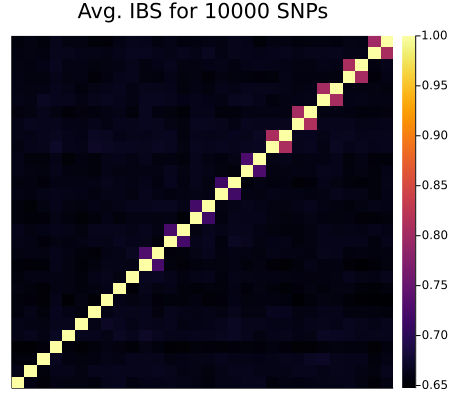

In [5]:
n_cols = 50 # number of colors
IBS_2 = ((X.==2) * (X.==2)' .+ (X.==1) * (X.==1)' .+ (X.==0) * (X.==0)') / p;
IBS_1 = ((X.==1) * ((X.==0) .| (X.==2))' .+ (X.==1) * ((X.==0) .| (X.==2))') / p
IBS = @. IBS_2 + 0.50 * IBS_1
heatmap(IBS, size=(450, 400), title="Avg. IBS for 10000 SNPs", 
        xaxis=nothing, yaxis=nothing)

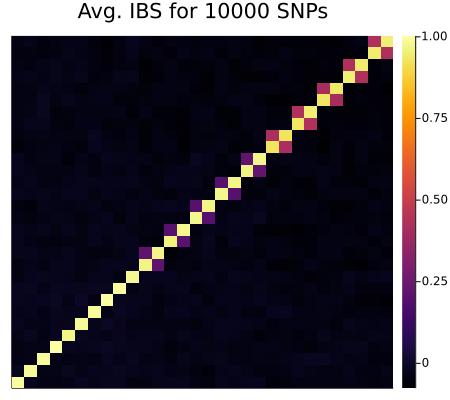

In [6]:
X_scaled = scale_data(X) # standardize each SNP at columns of X
GRM = (X_scaled * X_scaled') ./ p # correlation matrix of individuals based on standadized SNPs

heatmap(GRM, size=(450, 400), title="Avg. IBS for 10000 SNPs",
        xaxis=nothing, yaxis=nothing)

In [7]:
full_sibs = findall(grm -> 0.40 < grm < 0.60, GRM)
full_sibs = filter(x -> x.I[1] < x.I[2], full_sibs)
reduce(vcat, [[x.I[1], x.I[2]] for x ∈ full_sibs])

10-element Vector{Int64}:
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30

In [8]:
half_sibs = findall(grm -> 0.15 < grm < 0.35, GRM)
half_sibs = filter(x -> x.I[1] < x.I[2], half_sibs)
reduce(vcat, [[x.I[1], x.I[2]] for x ∈ half_sibs])

10-element Vector{Int64}:
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20

##### KING

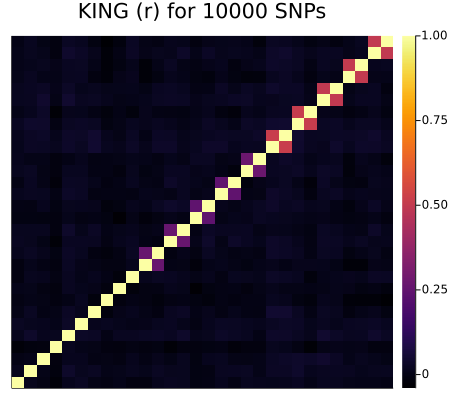

In [9]:
denominator = repeat(sum(X.==1, dims=2)', size(X, 1), 1) .+ repeat(sum(X.==1, dims=2), 1, size(X, 1))
king_r = 2 * ((X.==1) * (X.==1)' .- 2 * ((X.==0) * (X.==2)' + (X.==2) * (X.==0)')) ./ denominator

heatmap(king_r, size=(450, 400), title="KING (r) for 10000 SNPs",
        xaxis=nothing, yaxis=nothing)

## 5.2 Population Structure

### 5.2.1 Sources of population structure

##### Example 5.2: Genetic Drift

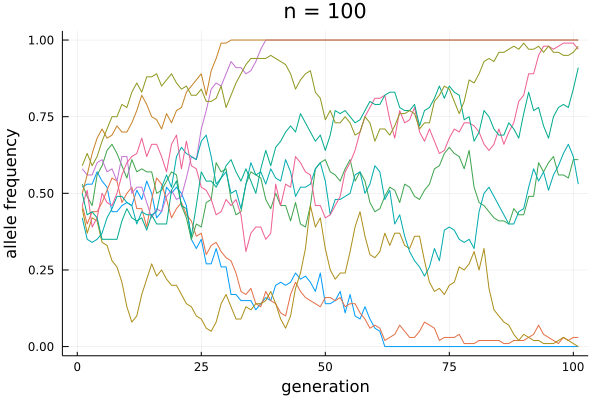

In [10]:
n = 100 # alleles in each generation of each population
f0 = 0.50  # starting allele frequency
K = 100 # number of generations in simulation
npop = 10 # Let's make 10 rather than just 2 pops to illustrate more general behavior
f = Matrix{Float64}(undef, npop, K+1) # results of allele freqs across pops and generation
for pop ∈ 1:npop
    a = rand(n) .< f0 # starting configuration of alleles
    f[pop, 1] = mean(a) # allele frequency at generation 0
    for ii ∈ 1:K
        a = rand(a, n) # resample generation ii
        f[pop, ii+1] = mean(a) # allele frequency at generation
    end
end

plot(f', label=nothing, title=@sprintf("n = %d", n),
     ylabel="allele frequency", xlabel="generation",
     xlims=[0, K], ylims=[0.0, 1.0])

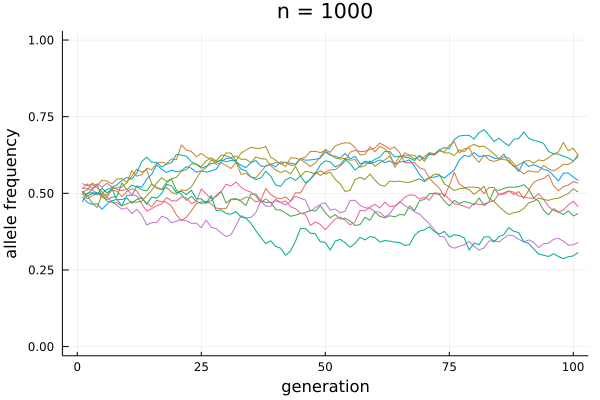

In [11]:
n = 1000 # alleles in each generation of each population
f0 = 0.50  # starting allele frequency
K = 100 # number of generations in simulation
npop = 10 # Let's make 10 rather than just 2 pops to illustrate more general behavior
f = Matrix{Float64}(undef, npop, K+1) # results of allele freqs across pops and generation
for pop ∈ 1:npop
    a = rand(n) .< f0 # starting configuration of alleles
    f[pop, 1] = mean(a) # allele frequency at generation 0
    for ii ∈ 1:K
        a = rand(a, n) # resample generation ii
        f[pop, ii+1] = mean(a) # allele frequency at generation
    end
end

plot(f', label=nothing, title=@sprintf("n = %d", n),
     ylabel="allele frequency", xlabel="generation",
     xlims=[0, K], ylims=[0.0, 1.0])

### 5.2.2 Principal component analysis (PCA)

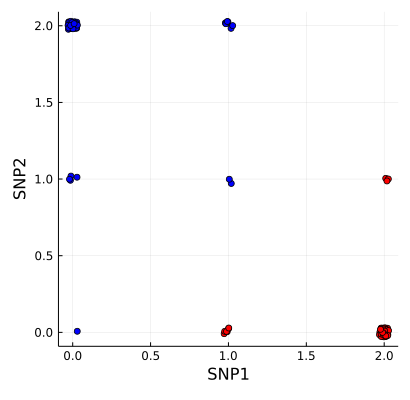

In [12]:
npop = 2
cols = ["blue", "red"]
f = [0.05 0.95; 0.95 0.05]
p = size(f, 2) # number of SNPs
n = fill(50, npop) # number of sample from each popluation
pop = repeat(1:npop, inner=n)
X = reduce(hcat,
    [
        reduce(vcat, [rand(Binomial(2, f[ii, jj]), n[jj]) for jj ∈ 1:npop])
        for ii ∈ 1:p
    ]
)
jitt_1 = rand(size(X, 1)) * 0.06 .- 0.03
jitt_2 = rand(size(X, 1)) * 0.06 .- 0.03
scatter(X[:, 1] .+ jitt_1, X[:, 2] .+ jitt_2, c=cols[pop],
    xlabel="SNP1", ylabel="SNP2", label=nothing, size=(410, 400))

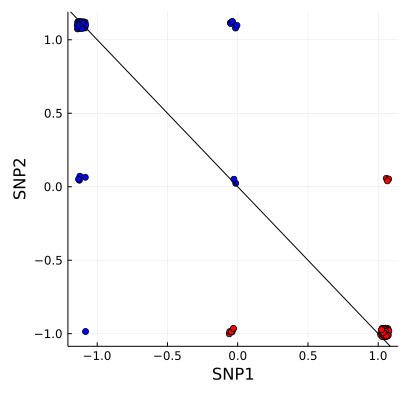

In [13]:
X = scale_data(X) # always standardize each variant before PCA
pca = fit(PCA, X', maxoutdim=1) # we are interested in only one output dimension
prj = projection(pca)
scatter(X[:, 1] .+ jitt_1, X[:, 2] .+ jitt_2, c=cols[pop],
    xlabel="SNP1", ylabel="SNP2", label=nothing, size=(410, 400))
Plots.abline!(prj[2, 1]/prj[1, 1], 0, label=nothing, c="black")

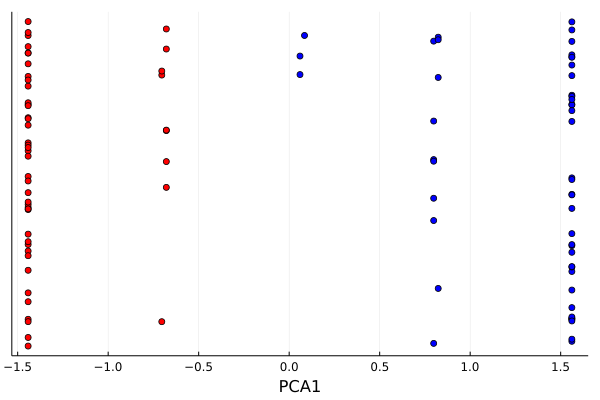

In [14]:
scatter(
    vec(MultivariateStats.transform(pca, X')), rand(100),
    c=cols[pop], label=nothing, yaxis=nothing, xlabel="PCA1"
)